### Necessary Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
import komm

plt.style.use("default")
plt.rcParams["figure.figsize"] = (6, 4)

### System Model

Defining Parameters

In [2]:
# System parameters
area = [-25, 25]  # area of the simulation m^2
M = 4  # number of users
N = 1  # number of base stations

eta = 4  # path loss exponent
Pt = np.linspace(-80, -20, 30)  # transmit power in dBm
Pt_lin = 10 ** (Pt / 10) / 1000  # transmit power in linear scale

bandwidth = 1e9  # bandwidth in Hz
noise = -170 + 10 * np.log10(bandwidth)  # noise power in dBm
noise_lin = 10 ** (noise / 10) / 1000  # noise power in linear scale
K = 5 * 10**4  # number of bits to be transmitted

Placing Users

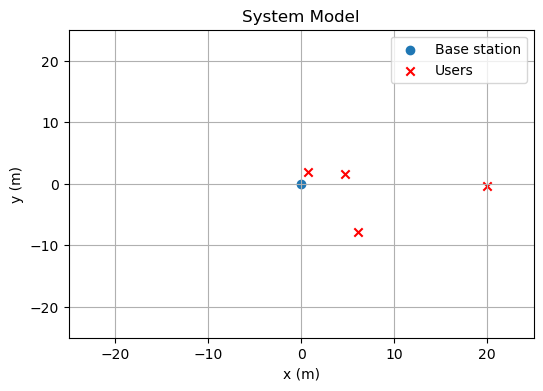

In [3]:
from matplotlib.markers import MarkerStyle

# Create a network with base station at the origin
bs = np.array([[0, 0]])
d = np.array([20, 10, 5, 2])  # distance from base station

theta = np.random.uniform(0, 2 * np.pi, size=M)
x = d * np.cos(theta)
y = d * np.sin(theta)
users = np.column_stack((x, y))

# Plot the network
plt.scatter(bs[:, 0], bs[:, 1], label="Base station")
plt.scatter(
    users[:, 0],
    users[:, 1],
    label="Users",
    marker=MarkerStyle("x"),
    color="r",
)
plt.legend()
plt.grid()
plt.title("System Model")
plt.xlim([area[0], area[1]])
plt.ylim([area[0], area[1]])
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.savefig("system_model.pdf", bbox_inches="tight")
plt.show()

In [4]:
distance_mat = np.sqrt(np.sum((users - bs[0]) ** 2, axis=1)).reshape(-1, 1)

print("Distance Matrix:")
print(distance_mat)

Distance Matrix:
[[20.]
 [10.]
 [ 5.]
 [ 2.]]


### Generate Channel Matrices

Rayleigh Fading Coefficients and Gain Matrix

In [5]:
h_mat = (
    np.sqrt(distance_mat ** (-eta))
    * (np.random.randn(M, K // 2) + 1j * np.random.randn(M, K // 2))
    / np.sqrt(2)
)

print("Channel Matrix:")
print(h_mat)

gain_mat = np.abs(h_mat) ** 2

print("\nGain Matrix:")
print(gain_mat.mean(axis=1))

Channel Matrix:
[[ 0.00075312-0.0041764j   0.00178874+0.00159135j  0.00058699-0.0004271j
  ... -0.00037831+0.0005326j   0.00087312+0.00052957j
  -0.00181689-0.00049265j]
 [ 0.00606814-0.00127966j -0.00458989-0.00563909j  0.01035709+0.01383998j
  ... -0.00474839+0.00068191j  0.0003336 +0.00822167j
   0.00308063-0.00539735j]
 [ 0.0041004 -0.04919992j -0.00326213-0.01238274j -0.00778986-0.02724929j
  ...  0.0364536 +0.00615757j -0.01001064-0.01171466j
  -0.01870478+0.01767342j]
 [ 0.14484336+0.17353561j  0.17444911+0.08459573j -0.12463142+0.1148078j
  ...  0.0957971 +0.36765121j  0.30009482+0.39404832j
  -0.11215222-0.25483553j]]

Gain Matrix:
[6.23136784e-06 9.86751214e-05 1.60563775e-03 6.24931758e-02]


Noise Matrix

In [6]:
noise_mat = (
    np.sqrt(noise_lin)
    * (np.random.randn(M, K // 2) + 1j * np.random.randn(M, K // 2))
    / np.sqrt(2)
)

print("Noise Matrix:")
print(noise_mat.mean(axis=1))

Noise Matrix:
[-1.36107205e-08+1.80574282e-08j -4.75856267e-09-2.13490123e-08j
 -1.48803403e-08-2.54926491e-08j  8.54512316e-09+4.58069384e-10j]


### Generating Data for Each User

Random Binary Data

In [7]:
# Generate random message bits for each user
x = np.random.randint(0, 2, size=(M, K))

print("Bits:")
print(x)

Bits:
[[1 1 1 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 [1 0 0 ... 1 0 1]
 [1 1 1 ... 1 0 1]]


QPSK Modulation

In [8]:
# Define the QPSK constellation
QPSK = komm.PSKModulation(4, phase_offset=np.pi / 4)

# Convert the input bits to QPSK symbols
x_qpsk = np.zeros((M, K // 2), dtype=complex)
for i in range(M):
    x_qpsk[i] = QPSK.modulate(x[i])

print("QPSK Symbols:")
print(x_qpsk)

QPSK Symbols:
[[-0.70710678-0.70710678j -0.70710678+0.70710678j  0.70710678-0.70710678j
  ...  0.70710678-0.70710678j  0.70710678+0.70710678j
   0.70710678+0.70710678j]
 [-0.70710678-0.70710678j  0.70710678+0.70710678j -0.70710678-0.70710678j
  ...  0.70710678+0.70710678j -0.70710678+0.70710678j
   0.70710678+0.70710678j]
 [-0.70710678+0.70710678j  0.70710678-0.70710678j  0.70710678-0.70710678j
  ... -0.70710678-0.70710678j  0.70710678-0.70710678j
   0.70710678-0.70710678j]
 [-0.70710678-0.70710678j -0.70710678+0.70710678j  0.70710678+0.70710678j
  ... -0.70710678-0.70710678j  0.70710678-0.70710678j
   0.70710678-0.70710678j]]


### Allocation Factors

In [9]:
# Create all possible combinations of allocation factors
alpha_combinations = []
for i in range(1, 101, 5):
    for j in range(1, 101 - i, 5):
        for k in range(1, 101 - i - j, 5):
            l = 100 - i - j - k
            new_alpha = np.array([i / 100, j / 100, k / 100, l / 100])
            if np.abs(np.sum(new_alpha) - 1) < 1e-9 and np.all(new_alpha > 0):
                alpha_combinations.append(new_alpha)

In [10]:
noma_sumrates, noma_userrates = zip(
    *[
        calculate_noma_rate(M, K, Pt_lin, combination, gain_mat, noise_lin)
        for combination in alpha_combinations
    ]
)
noma_sumrates = np.array(noma_sumrates)
noma_userrates = np.array(noma_userrates)

In [11]:
# Define power allocation coefficients
# to count user unfairness
alpha = np.array([0.55, 0.3, 0.15, 0.05])

# Find the allocation matrix yielding the highest achievable rate
max_index = np.argmax(noma_sumrates)
max_alpha = alpha_combinations[max_index]

print("Maximum Achievable Sum Rate:")
print(max(noma_sumrates[max_index]), "bps/Hz")

print("\nOptimal Allocation Matrix:")
print(max_alpha)

Maximum Achievable Sum Rate:
3.7715036777398154 bps/Hz

Optimal Allocation Matrix:
[0.01 0.06 0.46 0.47]


In [12]:
_, unfair_userrates = calculate_noma_rate(M, K, Pt_lin[-1], max_alpha, gain_mat, noise_lin)
_, fair_userrates = calculate_noma_rate(M, K, Pt_lin[-1], alpha, gain_mat, noise_lin)

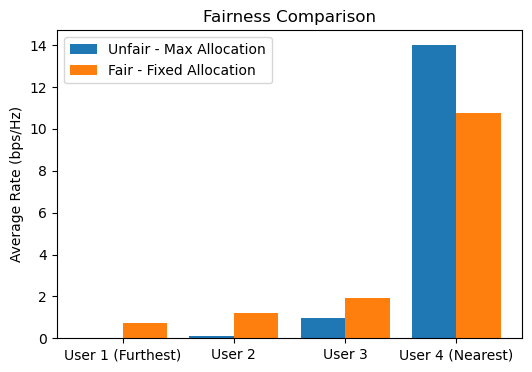

In [13]:
# Define user labels and x positions
user_labels = ["User 1 (Furthest)", "User 2", "User 3", "User 4 (Nearest)"]
x_positions = np.arange(len(user_labels))
bar_width = 0.4

# Each axis of userrates is the rate of a user
fig, ax = plt.subplots()
rects1 = ax.bar(
    x_positions - bar_width / 2,
    unfair_userrates.mean(axis=1),
    bar_width,
    label="Unfair - Max Allocation",
)
rects2 = ax.bar(
    x_positions + bar_width / 2,
    fair_userrates.mean(axis=1),
    bar_width,
    label="Fair - Fixed Allocation",
)
plt.xticks(x_positions, user_labels)
plt.ylabel("Average Rate (bps/Hz)")
plt.title("Fairness Comparison")
plt.legend()
plt.savefig("fairness_comparison.pdf", bbox_inches="tight")
plt.show()

In [14]:
# Define bandwidth allocation coefficients
beta_ofdma = (bandwidth / M) / bandwidth  # Bandwidth per user for OFDMA

### Transmitting and Receiving Data

Superposition Coded Signal

In [15]:
# Superposition coding
x_sc = (
    np.sqrt(alpha[0]) * x_qpsk[0]
    + np.sqrt(alpha[1]) * x_qpsk[1]
    + np.sqrt(alpha[2]) * x_qpsk[2]
    + np.sqrt(alpha[3]) * x_qpsk[3]
)

print("Superposition Coded Symbols:")
print(x_sc)

Superposition Coded Symbols:
[-1.34367792-0.79595536j -0.02135869+0.79595536j  0.56908125-1.02745015j
 ...  0.4797276 -0.56908125j  0.56908125+0.4797276j
  1.34367792+0.4797276j ]


Received Signal

In [16]:
y = np.zeros((len(Pt), M, K // 2), dtype=complex)
for i in range(len(Pt)):
    y[i] = np.sqrt(Pt_lin[i]) * x_sc * h_mat + noise_mat

# Perform equalization
y_eq = np.zeros((len(Pt), M, K // 2), dtype=complex)
for i in range(len(Pt)):
    for j in range(M):
        y_eq[i, j] = y[i, j] / h_mat[j]

print("Equalized Symbols:")
print(y_eq.shape)

Equalized Symbols:
(30, 4, 25000)


### NOMA vs OFDMA Capacity

Compute NOMA and OFDMA Sum Capacity

In [17]:
noma_sumrate, _ = calculate_noma_rate(M, K, Pt_lin, alpha, gain_mat, noise_lin)
ofdma_sumrate, _ = calculate_ofdma_rate(M, K, Pt_lin, gain_mat, noise_lin, beta_ofdma)

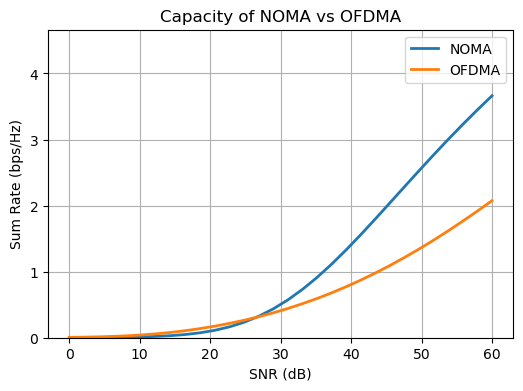

In [18]:
# Plot the sum capacity of NOMA and OFDMA vs SNR
SNR = Pt - noise
plt.figure()
plt.plot(SNR, noma_sumrate, linewidth=2)
plt.plot(SNR, ofdma_sumrate, linewidth=2)
plt.xlabel("SNR (dB)")
plt.ylabel("Sum Rate (bps/Hz)")
plt.legend(["NOMA", "OFDMA"])
plt.title("Capacity of NOMA vs OFDMA")
plt.ylim([0, max(noma_sumrate) + 1])
plt.grid(True)
plt.savefig("noma_vs_ofdma.pdf", bbox_inches="tight")
plt.show()

### Decoding with SIC

In [ ]:
x_hat = np.zeros((len(Pt), M, K), dtype=int)

for i in range(len(Pt)):
    # Perform decoding of signal at user 1
    x_hat[i, 0] = QPSK.demodulate(y_eq[i, 0])  # Direct decoding

    # Perform decoding of signal at user 2
    u1_hat = QPSK.demodulate(y_eq[i, 1])  # Decode user 1 signal
    u1_remod = QPSK.modulate(u1_hat)  # Remodulate user 1 signal
    rem_u1 = y_eq[i, 1] - (np.sqrt(alpha[0] * Pt_lin[i]) * u1_remod)
    x_hat[i, 1] = QPSK.demodulate(rem_u1)  # Decode user 2 signal

    # Perform decoding of signal at user 3
    u1_hat = QPSK.demodulate(y_eq[i, 2])  # Decode user 1 signal
    u1_remod = QPSK.modulate(u1_hat)  # Remodulate user 1 signal
    u2_hat = QPSK.demodulate(
        y_eq[i, 2] - (np.sqrt(alpha[0] * Pt_lin[i]) * u1_remod)
    )  # Decode user 2 signal
    u2_remod = QPSK.modulate(u2_hat)  # Remodulate user 2 signal
    x_hat[i, 2] = QPSK.demodulate(
        y_eq[i, 2]
        - (np.sqrt(alpha[0] * Pt_lin[i]) * u1_remod)
        - (np.sqrt(alpha[1] * Pt_lin[i]) * u2_remod)
    )  # Decode user 3 signal

    # Perform decoding of signal at user 4
    u1_hat = QPSK.demodulate(y_eq[i, 3])  # Decode user 1 signal
    u1_remod = QPSK.modulate(u1_hat)  # Remodulate user 1 signal
    u2_hat = QPSK.demodulate(
        y_eq[i, 3] - (np.sqrt(alpha[0] * Pt_lin[i]) * u1_remod)
    )  # Decode user 2 signal
    u2_remod = QPSK.modulate(u2_hat)  # Remodulate user 2 signal
    u3_hat = QPSK.demodulate(
        y_eq[i, 3]
        - (np.sqrt(alpha[0] * Pt_lin[i]) * u1_remod)
        - (np.sqrt(alpha[1] * Pt_lin[i]) * u2_remod)
    )  # Decode user 3 signal
    u3_remod = QPSK.modulate(u3_hat)  # Remodulate user 3 signal
    x_hat[i, 3] = QPSK.demodulate(
        y_eq[i, 3]
        - (np.sqrt(alpha[0] * Pt_lin[i]) * u1_remod)
        - (np.sqrt(alpha[1] * Pt_lin[i]) * u2_remod)
        - (np.sqrt(alpha[2] * Pt_lin[i]) * u3_remod)
    )  # Decode user 4 signal

print("Decoded Bits:")
print(x_hat)